In [1]:
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# CONTEXT

| Column  | Description  |
|---|---|
| Price  | Price in US dollars (326-18,823)  |
| Carat  | Weight of the diamond (0.2--5.01)  |
| Cut  | Quality of the cut (Fair, Good, Very Good, Premium, Ideal)  |
| Color  | Diamond colour, from J (worst) to D (best)  |
| Clarity  | A measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))   |
| x  | Length in mm (0--10.74)  |
| y  | Width in mm (0--58.9)  |
| z  | Depth in mm (0--31.8)  |
| Depth  | Total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)  |
| Table  | Width of top of diamond relative to widest point (43--95)  |

# Predicting diamonds price

In [2]:
#dataset to train your model
diamonds = pd.read_csv("diamonds.csv", index_col=False)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
1,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
2,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
3,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
4,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48


In [3]:
def creating_classification(df):
    '''this function it is used to classify diamonds measures'''
    
    #clarity 0(worst), 7(best)
    clarity_classification = {'I1' : 0, 'SI2': 1, 'SI1':2, 'VS2':3, 'VS1':4, 'VVS2':5, 'VVS1':6, 'IF':7}
    df['clarity_number'] = df['clarity'].map(clarity_classification)
    
    #color 0(worst), 6(best)
    color_classification = {'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}
    df['color_number'] = df['color'].map(color_classification)
    
    #cut 0(worst), 4(best)
    cut_classification = {'Fair': 0, 'Good': 1, 'Very Good':2, 'Premium': 3, 'Ideal':4}
    df['cut_number'] = df['cut'].map(cut_classification)

In [4]:
creating_classification(diamonds)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,clarity_number,color_number,cut_number
0,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,2,5,3
1,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,4,5,1
2,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,3,1,3
3,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,1,0,1
4,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,5,0,2


# CLEANING DATA

In [5]:
#values where x, y and z can be 0
mask = (diamonds['x'] == 0) | (diamonds['y'] == 0) | (diamonds['z'] == 0)
diamonds.loc[mask,:].head()

,carat,cut,color,clarity,depth,table,price,x,y,z,clarity_number,color_number,cut_number
2010,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0,1,3,3
2104,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0,0,2,3
4323,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0,1,3,3
4941,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0,1,4,3
9187,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0,0,3,1


In [6]:
#function to validate z
def calculate_z(df, x='x', y='y', z='z', depth='depth'):
    '''  formula'''
    for row in range(df.shape[0]):
        if df[z][row] == 0:
            df[z][row] = (df[x][row] + df[y][row]) * df[depth][row] / 200

In [7]:
calculate_z(df=diamonds)

<ipython-input-6-f9d9b5818ca0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[z][row] = (df[x][row] + df[y][row]) * df[depth][row] / 200


In [8]:
#replacing 0 values to nan values
diamonds['z'] = diamonds['z'].replace(0, np.nan)
diamonds['x'] = diamonds['x'].replace(0, np.nan)
diamonds['y'] = diamonds['y'].replace(0, np.nan)

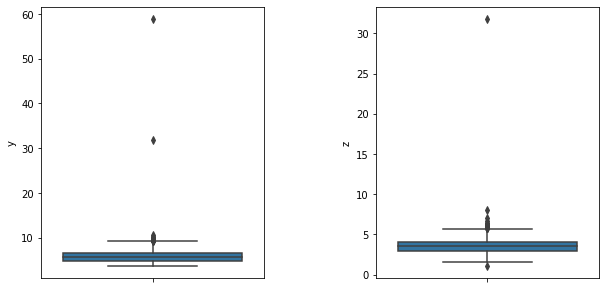

In [9]:
#outliers
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.boxplot(y=diamonds.y, ax=ax[0])
sns.boxplot(y=diamonds.z, ax=ax[1])
plt.subplots_adjust(wspace=0.5)

In [10]:
#check outliers / wrong values
mask = (diamonds['y'] > 10) | (diamonds['z'] > 6)
diamonds.loc[mask,:]

,carat,cut,color,clarity,depth,table,price,x,y,z,clarity_number,color_number,cut_number
21444,3.65,Fair,H,I1,67.1,53.0,11668,9.53,9.48,6.38,0,2,0
21828,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06,1,2,3
22066,3.50,Ideal,H,I1,62.8,57.0,12587,9.65,9.59,6.03,0,2,4
23577,4.01,Premium,I,I1,61.0,61.0,15223,10.14,10.10,6.17,0,1,3
23578,4.01,Premium,J,I1,62.5,62.0,15223,10.02,9.94,6.24,0,0,3
23751,2.01,Fair,G,SI2,65.6,56.0,15562,7.89,7.84,6.16,1,3,0
23958,3.40,Fair,D,I1,66.8,52.0,15964,9.42,9.34,6.27,0,6,0
23971,4.00,Very Good,I,I1,63.3,58.0,15984,10.01,9.94,6.31,0,1,2
24049,3.67,Premium,I,I1,62.4,56.0,16193,9.86,9.81,6.13,0,1,3
24851,5.01,Fair,J,I1,65.5,59.0,18018,10.74,10.54,6.98,0,0,0


In [11]:
mask = (diamonds['z'] > 30)
diamonds.loc[mask,['z']] = 0

In [12]:
calculate_z(diamonds)

<ipython-input-6-f9d9b5818ca0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[z][row] = (df[x][row] + df[y][row]) * df[depth][row] / 200


In [13]:
mask = (diamonds['y'] > 30)
diamonds.loc[mask,['y']] = 0

In [14]:
#function to calculate y
def calculate_y(df, x='x', y='y', z='z', depth='depth'):
    for row in range(df.shape[0]):
        if df[y][row] == 0:
            df[y][row] = round((200 *df[z][row] / df[depth][row]) - df[x][row],2)

In [15]:
calculate_y(diamonds)

<ipython-input-14-8af7b61c1119>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[y][row] = round((200 *df[z][row] / df[depth][row]) - df[x][row],2)


In [16]:
diamonds.dropna(inplace=True)

In [17]:
diamonds.describe()

,carat,depth,table,price,x,y,z,clarity_number,color_number,cut_number
count,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000,48933.000000
mean,0.797748,61.751904,57.451041,3933.641592,5.731532,5.733792,3.539596,3.055504,3.407251,2.906484
std,0.474093,1.429933,2.232986,3988.524750,1.119905,1.113872,0.692143,1.645522,1.699909,1.116507
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000,2.000000,2.000000,2.000000
50%,0.700000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.520000,3.000000,3.000000,3.000000
75%,1.040000,62.500000,59.000000,5331.000000,6.540000,6.540000,4.040000,4.000000,5.000000,4.000000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,19.280000,8.060000,7.000000,6.000000,4.000000


# DATA ANALYSIS

In [18]:
diamonds.groupby(by=['color']).mean() 

,carat,depth,table,price,x,y,z,clarity_number,color_number,cut_number
color,,,,,,,,,,
D,0.656904,61.707891,57.384868,3162.202468,5.415491,5.419706,3.342418,2.695730,6.0,2.933106
E,0.658942,61.660785,57.490585,3091.383020,5.413941,5.419202,3.339072,2.975871,5.0,2.896042
F,0.736225,61.701607,57.420425,3722.164490,5.616532,5.620319,3.466205,3.139984,4.0,2.886140
G,0.770016,61.757540,57.290170,3989.929995,5.676257,5.678986,3.506356,3.470102,3.0,2.989985
H,0.909698,61.833515,57.518740,4475.434748,5.980141,5.977198,3.696404,2.937003,2.0,2.881432
I,1.030982,61.853078,57.570239,5121.677848,6.230671,6.230626,3.851678,2.958069,1.0,2.879935
J,1.164531,61.888268,57.798701,5342.467323,6.523567,6.523402,4.036268,2.778740,0.0,2.735039


In [19]:
mask = diamonds['carat'] < 1
color_carat = diamonds.loc[mask,:]
color_carat.groupby(by=['color']).mean() 

,carat,depth,table,price,x,y,z,clarity_number,color_number,cut_number
color,,,,,,,,,,
D,0.501900,61.717015,57.167787,1752.265971,5.026889,5.033409,3.104090,2.836117,6.0,3.029645
E,0.497061,61.644799,57.328861,1657.486160,5.009650,5.017245,3.089667,3.182110,5.0,2.982226
F,0.520105,61.661179,57.225614,1731.873936,5.083675,5.091840,3.136858,3.394390,4.0,2.953415
G,0.494841,61.749637,57.071094,1553.618918,5.000180,5.008691,3.090476,3.777727,3.0,3.052886
H,0.515981,61.852966,57.186283,1551.691547,5.050559,5.057088,3.125596,3.589224,2.0,2.961691
I,0.541766,61.923405,57.130038,1511.391635,5.134001,5.144804,3.182408,3.625264,1.0,2.970004
J,0.585615,61.923992,57.449899,1454.071573,5.282056,5.289466,3.271865,3.211694,0.0,2.766129


In [20]:
diamonds2 = diamonds[['price','carat','depth','table','x','y','z','clarity_number','color_number','cut_number']]

In [41]:
diamonds2.corr()

,price,carat,depth,table,x,y,z,clarity_number,color_number,cut_number
price,1.000000,0.922207,-0.012077,0.127854,0.887904,0.888406,0.882634,-0.148749,-0.173196,-0.055211
carat,0.922207,1.000000,0.027063,0.181726,0.977852,0.975783,0.976413,-0.353867,-0.292033,-0.136266
depth,-0.012077,0.027063,1.000000,-0.296986,-0.025812,-0.029206,0.095818,-0.067473,-0.046311,-0.220212
table,0.127854,0.181726,-0.296986,1.000000,0.196061,0.189521,0.155739,-0.160685,-0.027518,-0.431637
x,0.887904,0.977852,-0.025812,0.196061,1.000000,0.997382,0.991046,-0.373606,-0.271145,-0.127663
y,0.888406,0.975783,-0.029206,0.189521,0.997382,1.000000,0.990543,-0.367676,-0.270641,-0.126914
z,0.882634,0.976413,0.095818,0.155739,0.991046,0.990543,1.000000,-0.376994,-0.275367,-0.153875
clarity_number,-0.148749,-0.353867,-0.067473,-0.160685,-0.373606,-0.367676,-0.376994,1.000000,-0.024651,0.189489
color_number,-0.173196,-0.292033,-0.046311,-0.027518,-0.271145,-0.270641,-0.275367,-0.024651,1.000000,0.020303
cut_number,-0.055211,-0.136266,-0.220212,-0.431637,-0.127663,-0.126914,-0.153875,0.189489,0.020303,1.000000


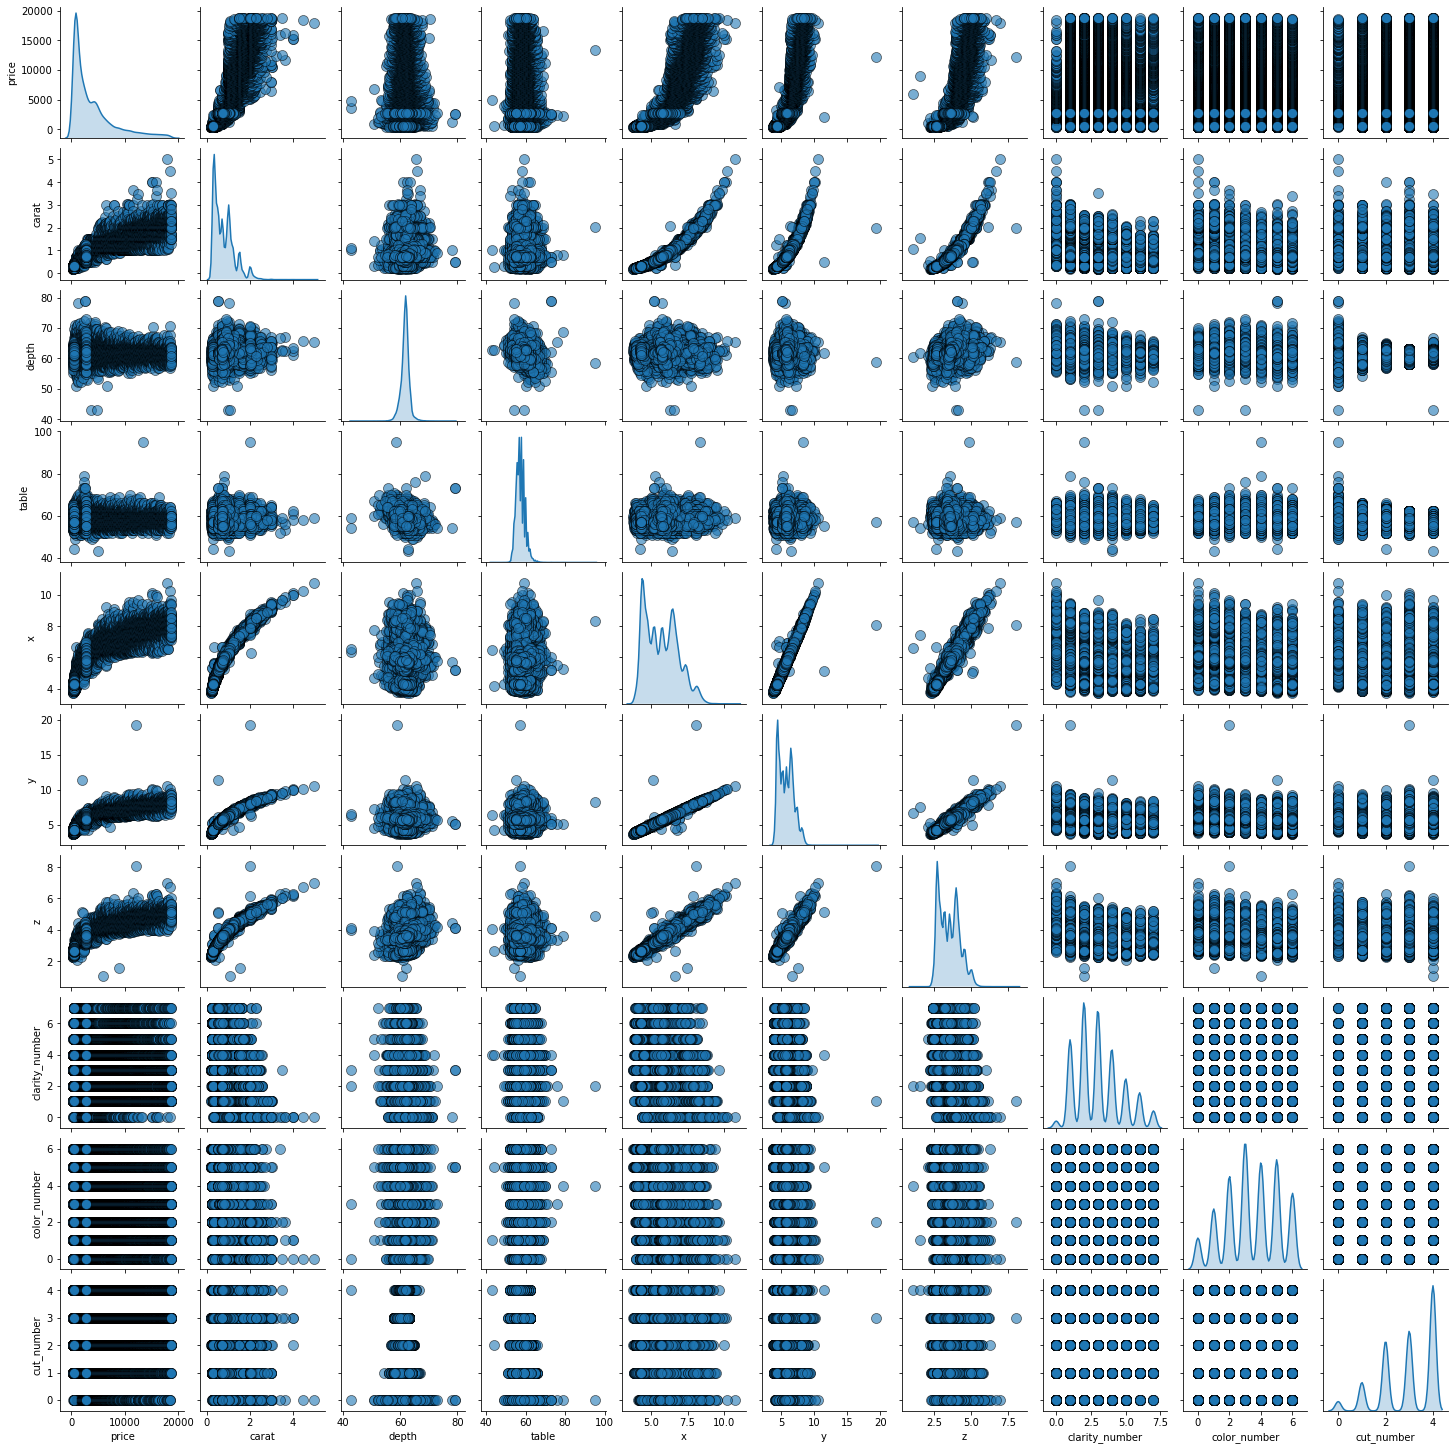

In [21]:
sns.pairplot(diamonds2, diag_kind = 'kde', height=2, plot_kws = {'alpha': 0.6, 's': 100, 'edgecolor': 'k'})

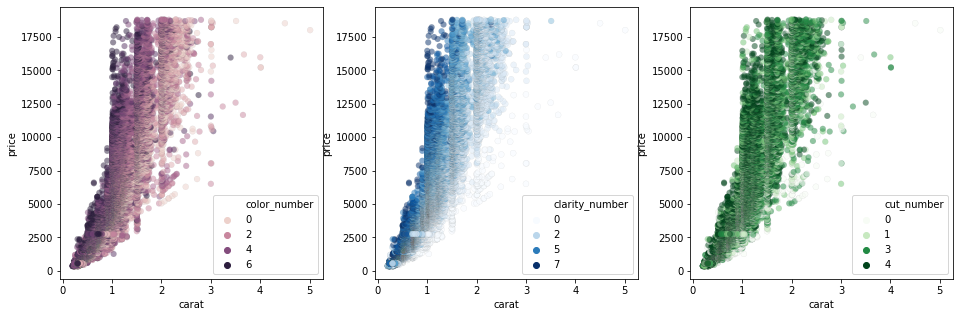

In [22]:
#those graphs compare carat with price and use color, clarity and cut as labels
kwargs  =   {'edgecolor':"#717572", 'linewidth':.1}

f, ax = plt.subplots(1, 3, figsize=(16,5))

sns.scatterplot(diamonds.carat, diamonds.price, hue=diamonds['color_number'], ax=ax[0], alpha=0.5, **kwargs)
sns.scatterplot(diamonds.carat, diamonds.price, hue=diamonds['clarity_number'], ax=ax[1],palette='Blues', alpha=0.5, **kwargs)
sns.scatterplot(diamonds.carat, diamonds.price, hue=diamonds['cut_number'], ax=ax[2],palette='Greens', alpha=0.5,**kwargs)

plt.show()

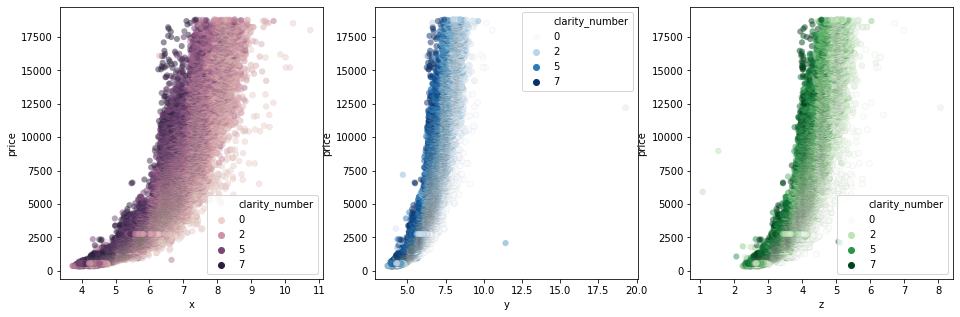

In [23]:
#those graphs compare x,y,z with price
kwargs  =   {'edgecolor':"#717572", 'linewidth':.1}

f, ax = plt.subplots(1, 3, figsize=(16,5))

sns.scatterplot(diamonds.x, diamonds.price, hue=diamonds['clarity_number'], ax=ax[0], alpha=0.5, **kwargs)
sns.scatterplot(diamonds.y, diamonds.price, hue=diamonds['clarity_number'], ax=ax[1],palette='Blues', alpha=0.5, **kwargs)
sns.scatterplot(diamonds.z, diamonds.price, hue=diamonds['clarity_number'], ax=ax[2],palette='Greens', alpha=0.5,**kwargs)

plt.show()

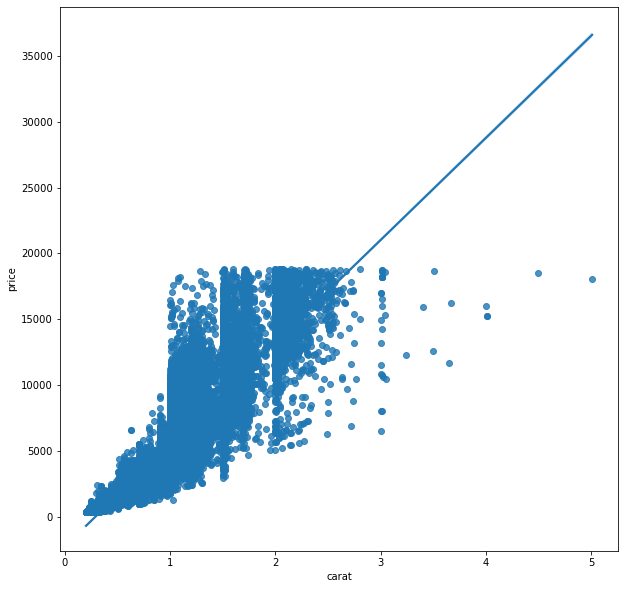

In [24]:
plt.figure(figsize=(10, 10))
sns.regplot(diamonds.carat, diamonds.price, scatter=True)


# TESTING MODEL

## 1 MODEL

In [25]:
X = diamonds[['carat', 'color_number', 'cut_number']]
y = diamonds['price']

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LinearRegression()

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
model.fit(X_train_std, y_train)

X_test_std = scaler.transform(X_test)
predictions = model.predict(X_test_std)

np.sqrt(mean_squared_error(y_test, predictions))

1489.23193890025

## 2 MODEL - USING CLARITY TO SEPARETE DIAMONDS

In [26]:
for x in range(8):
    mask1 = (diamonds['clarity_number'] == x)
    diamonds_clarity_0 = diamonds.loc[mask1,:]
    X = diamonds_clarity_0[['carat','color_number','cut_number','y','x']]
    y = diamonds_clarity_0['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = LinearRegression()
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = scaler.transform(X_train)
    model.fit(X_train_std, y_train)
    X_test_std = scaler.transform(X_test)
    predictions = model.predict(X_test_std)

    print(f'clarity = {x}  RMSE = {np.sqrt(mean_squared_error(y_test, predictions))}')

clarity = 0  RMSE = 670.624288113008
clarity = 1  RMSE = 1031.8986921271749
clarity = 2  RMSE = 780.7092434955099
clarity = 3  RMSE = 935.151810567853
clarity = 4  RMSE = 970.4391290757819
clarity = 5  RMSE = 995.9005378670124
clarity = 6  RMSE = 969.3493171523069
clarity = 7  RMSE = 1287.0398594091412


# Rick's diamonds

In [27]:
rick = pd.read_csv('rick_diamonds.csv')

In [28]:
mask = (rick['x'] == 0) | (rick['y'] == 0) | (rick['z'] == 0)
rick.loc[mask,:].head()

,carat,cut,color,clarity,depth,table,x,y,z
2427,1.12,Premium,G,I1,60.4,59.0,6.71,6.67,0.0
2460,0.71,Good,F,SI2,64.1,60.0,0.00,0.00,0.0


In [29]:
rick.describe()

,carat,depth,table,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.799144,61.724680,57.516140,5.735516,5.736410,3.539576
std,0.472936,1.457691,2.244019,1.120300,1.110345,0.694733
min,0.200000,44.000000,50.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,4.720000,4.720000,2.910000
50%,0.710000,61.800000,57.000000,5.710000,5.720000,3.530000
75%,1.040000,62.500000,59.000000,6.530000,6.520000,4.032500
max,4.130000,73.600000,70.000000,10.000000,9.850000,6.430000


In [30]:
creating_classification(rick)
rick.head()

,carat,cut,color,clarity,depth,table,x,y,z,clarity_number,color_number,cut_number
0,0.91,Very Good,H,SI2,63.4,57.0,6.10,6.18,3.89,1,2,2
1,0.38,Good,F,VS2,60.3,61.0,4.68,4.71,2.83,3,4,1
2,0.52,Ideal,H,VS2,61.8,56.0,5.19,5.16,3.20,3,2,4
3,1.10,Ideal,G,VS1,61.3,56.0,6.65,6.69,4.09,4,3,4
4,2.28,Ideal,G,SI2,61.6,57.0,8.44,8.37,5.18,1,3,4


In [31]:
def predit_diamonds(df, df_model):

    #criando modelo de previsão
    for clarity in range(8):
        #separa o dataset por claridade do diamante
        mask = (df_model['clarity_number'] == clarity)
        diamonds_clarity = df_model.loc[mask,:]
       
        #dados utilizados para prever treinar o modelo
        
        columns_predict = ['carat','y','x']
        
        X = diamonds_clarity[columns_predict]
        y = diamonds_clarity['price']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        
        #treinando o modelo
        model = LinearRegression()
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_std = scaler.transform(X_train)
        model.fit(X_train_std, y_train)
    
    
        #testando o modelo    
        X_test_std = scaler.transform(X_test)
        predictions_test = model.predict(X_test_std)
    
        print(f'claridade {clarity}, erro {np.sqrt(mean_squared_error(y_test, predictions_test))}')
    
    
        #prevendo os dados
        mask = (df['clarity_number'] == clarity)
        diamonds_predict = df.loc[mask,:]
    
    
    
        X_predict = diamonds_predict[columns_predict]
        #print(X_predict)
        X_predict_std = scaler.transform(X_predict)
        predictions = model.predict(X_predict_std)
        
        #incluindo valores no dataset
        
        df.loc[mask,'price_predicted'] = predictions

In [32]:
predit_diamonds(rick, diamonds)

claridade 0, erro 867.9790682728249
claridade 1, erro 1414.018770448876
claridade 2, erro 935.8022138733413
claridade 3, erro 1139.9700304108735
claridade 4, erro 1244.6821690974377
claridade 5, erro 1236.2183522738985
claridade 6, erro 1041.4052079557337
claridade 7, erro 1204.3115927967278


In [33]:
rick.head()

,carat,cut,color,clarity,depth,table,x,y,z,clarity_number,color_number,cut_number,price_predicted
0,0.91,Very Good,H,SI2,63.4,57.0,6.10,6.18,3.89,1,2,2,3993.216386
1,0.38,Good,F,VS2,60.3,61.0,4.68,4.71,2.83,3,4,1,739.317163
2,0.52,Ideal,H,VS2,61.8,56.0,5.19,5.16,3.20,3,2,4,1618.328475
3,1.10,Ideal,G,VS1,61.3,56.0,6.65,6.69,4.09,4,3,4,6847.759993
4,2.28,Ideal,G,SI2,61.6,57.0,8.44,8.37,5.18,1,3,4,15173.758029


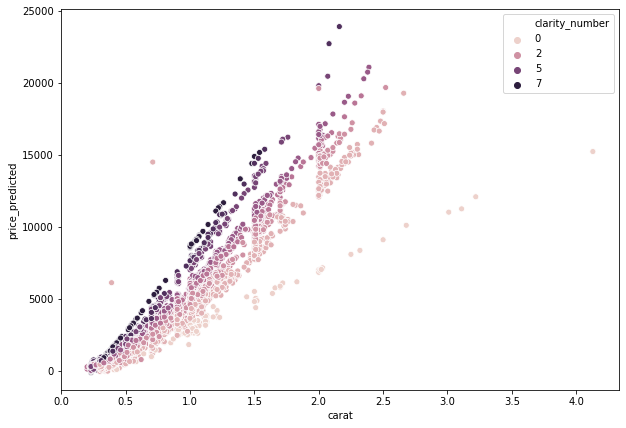

In [34]:
plt.figure(figsize=(10, 7))
sns.scatterplot(rick['carat'], rick['price_predicted'], hue = rick['clarity_number']);

# Rick's diamonds 2

In [35]:
def predit_diamonds_lower(df, df_model):

    columns_predict = ['carat','y','x']    
    
    mask = df_model['carat'] < .5
    df_model = df_model.loc[mask,:]
        
    X = df_model[columns_predict]
    y = df_model['price']
        
    mask = df['price_predicted'] < 300
    df2 = df.loc[mask,:]
        
    model = LinearRegression()
    scaler = StandardScaler()
        
    #training the model
    scaler.fit(X)
    X_std = scaler.transform(X) 
    model.fit(X_std, y)        
        
    X_predict = df2[columns_predict]

    X_predict_std = scaler.transform(X_predict)
    predictions_low = model.predict(X_predict_std)

    df.loc[mask,'price_predicted'] = predictions_low

In [36]:
predit_diamonds_lower(rick,diamonds)

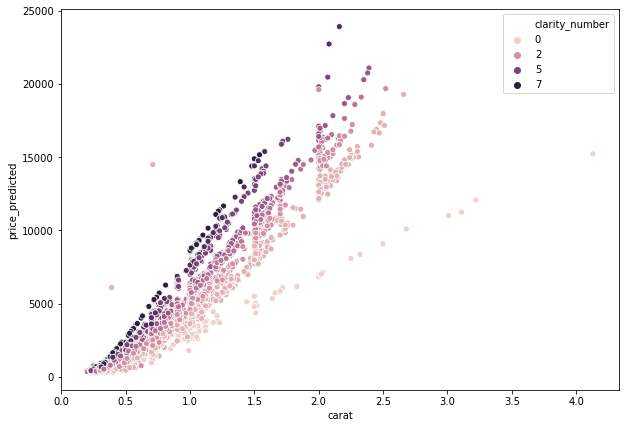

In [37]:
plt.figure(figsize=(10, 7))
sns.scatterplot(rick['carat'], rick['price_predicted'], hue = rick['clarity_number']);

In [38]:
rick.describe()

,carat,depth,table,x,y,z,clarity_number,color_number,cut_number,price_predicted
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,0.799144,61.724680,57.516140,5.735516,5.736410,3.539576,3.007600,3.39160,2.881400,3934.305562
std,0.472936,1.457691,2.244019,1.120300,1.110345,0.694733,1.662196,1.71337,1.116774,3817.674132
min,0.200000,44.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,300.108637
25%,0.400000,61.000000,56.000000,4.720000,4.720000,2.910000,2.000000,2.00000,2.000000,874.325120
50%,0.710000,61.800000,57.000000,5.710000,5.720000,3.530000,3.000000,3.00000,3.000000,2674.967393
75%,1.040000,62.500000,59.000000,6.530000,6.520000,4.032500,4.000000,5.00000,4.000000,5628.256196
max,4.130000,73.600000,70.000000,10.000000,9.850000,6.430000,7.000000,6.00000,4.000000,23909.927039


![title](gaga_diamonds.jpeg)

# EXPORTANDO

In [229]:
rick_site = rick[['carat','cut','color','clarity','depth','table','x','y','z','price_predicted']]

In [ ]:

#primeiro modelo fazer a media

#fazer log do carat pelo log do preço
#quando aplica o log cai numa relação mais linear

#analisar os coeficientes
#log10 para voltar 10 elevado ao valor real

#PLOTAR RESIDUO